In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *

In [2]:
def make_model():
    """
    shallow CNN
    """
    inpt = Input(shape=(28,28,1))
    x = Conv2D(32, 3, padding='same', activation='relu')(inpt)

    for i in range(3):
        _x = Conv2D(32, 3, padding='same', activation='relu')(x)
        x = Add()([_x, x])
        x = MaxPooling2D(2)(x)

    x = Conv2D(8, 3, padding='same', activation='relu')(x)
    x = Flatten()(x)
    x = Dense(10, activation='softmax')(x)
    return keras.Model(inpt, x)

In [3]:
import numpy as np

(x_tr, y_tr), (x_va, y_va) = tf.keras.datasets.mnist.load_data()
x_tr = (2.*x_tr/255. - 1)[...,np.newaxis].astype('float32')
x_va = (2.*x_va/255. - 1)[...,np.newaxis].astype('float32')
y_tr = np.eye(10)[y_tr].astype('float32')
y_va = np.eye(10)[y_va].astype('float32')

In [4]:
x_tr.shape, x_va.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [5]:
import importlib as ilib
import optimizer 
ilib.reload(optimizer)

import train_loop
ilib.reload(train_loop)

<module 'train_loop' from '/home/mshlis/Projects/cubic_optimizer/train_loop.py'>

In [6]:
batch_sizes = [4096, 2048, 1024, 512, 256, 128]

In [ ]:
from tqdm import tqdm

cubic_losses = {}
sgd_losses = {}

def CE(y_true, y_pred):
    loss = -tf.reduce_sum(y_true*tf.math.log(y_pred+1e-5), axis=-1)
    return tf.reduce_mean(loss)

epochs = 300
N = 4096
for batch_size in tqdm(batch_sizes):
    dataset = tf.data.Dataset.from_tensor_slices((x_tr[:N], y_tr[:N])).shuffle(N).batch(batch_size)
    opt = optimizer.CubicStep(learning_rate=1e-2, name='cubic', warmup_steps=25*N//batch_size)
    optimizer_use_loss = True
    
    model = make_model()
    weights = model.get_weights()
    cubic_losses[batch_size] = train_loop.train(model, 
                                                dataset, 
                                                opt, 
                                                CE, 
                                                epochs, 
                                                True,
                                                verbose=0)
    
    tf.keras.backend.clear_session()
    
    opt = keras.optimizers.SGD(1e-2)
    optimizer_use_loss = False
    
    model.set_weights(weights)
    sgd_losses[batch_size] = train_loop.train(model, 
                                              dataset, 
                                              opt, 
                                              CE, 
                                              epochs, 
                                              False,
                                              verbose=0)    
    
    tf.keras.backend.clear_session()

 33%|███▎      | 2/6 [02:07<04:15, 63.82s/it]

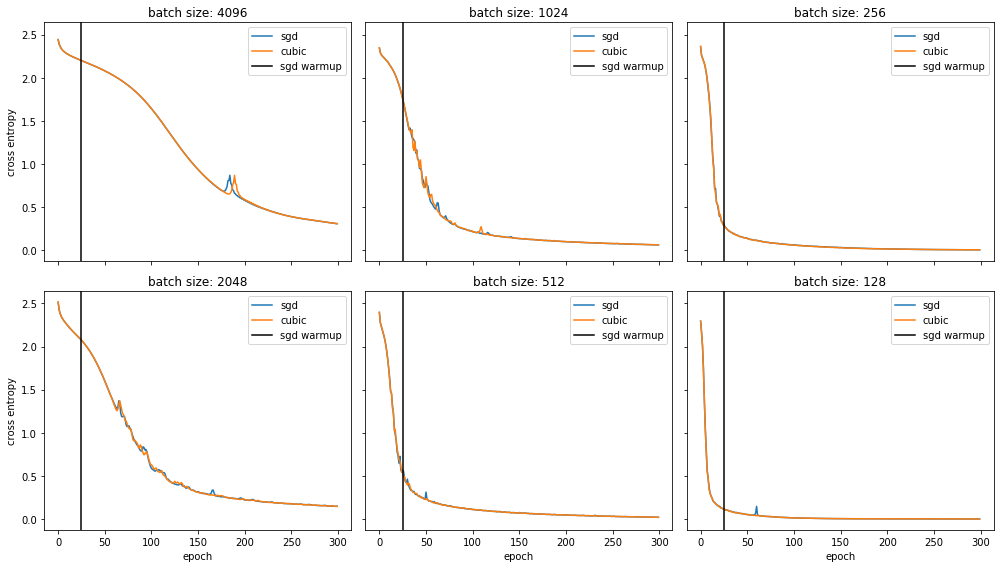

In [28]:
from matplotlib import pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(2, 3, sharey=True, sharex=True, figsize=(14,8))
for i, batch_size in enumerate(batch_sizes):
    ax[i%2, i//2].plot(sgd_losses[batch_size], label='sgd')
    ax[i%2, i//2].plot(cubic_losses[batch_size], label='cubic')
    ax[i%2, i//2].axvline(25, color='black', label='sgd warmup')
    
    if i%2: ax[i%2, i//2].set_xlabel('epoch')
    if not i//2: ax[i%2, i//2].set_ylabel('cross entropy')
    
    ax[i%2, i//2].legend()
    ax[i%2, i//2].set_title(f'batch size: {batch_size}')
plt.tight_layout()